# The Enron Corpus
## A practice in EDA and Machine Learning
##### Tania Lincoln January 15, 2018

### Background
Enron was one of the largest corporations in the United States.  By December 2002, it was bankrupt due to widespread corporate fraud and misleading accouting practices.  A Federal investigation resulted where many leaders were found guilty.

The Enron dataset contains approximately 600,000 emails generated by 158 employees of the Enron Corporation.  It was obtained by the Federal Energy Regulatory Commission during Enron's collapse.  At the conclusion of the investigation, the emails and information collected were deemed to be public domain to be used for research or academic purposes.

The corpus is unique in that its one of the only public mass collections of real emails available for study.

### Summary
In this project, we will study the corpus to build a person of interest identifier using emails and financial data.  A person of interest is someone who was indicted for fraud, settled, or testified in exchange for immunity.

This document will step through the EDA techniques to understand and clean the data; and explain machine learning algorithms applied to identify a person of interest.  Machine learning uses pattern recognition and statistics in a programatically to predict outcomes.

### Import Libraries

In [53]:
#import basic libraries
import sys
import pickle
import numpy as np
import pandas as pd
import csv
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pprint

# add this path statement in order to add custom libraries
sys.path.append("../../ud120-projects-master/tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

sys.path.append("../utilities/")
from tool import scatter_plot

%matplotlib inline
pd.set_option('display.max_columns', None)

### Display Current Environment Info

In [2]:
# Always good practice to note the version info
print("python " + sys.version)
print("")
print("pandas " + str(pd.__version__))
print("numpy " + np.__version__)
print("matplotlib " + mpl.__version__)
print("seaborn " + sns.__version__)
print("stats " + statsmodels.__version__)

python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]

pandas 0.19.2
numpy 1.13.1
matplotlib 2.0.0
seaborn 0.7.1
stats 0.6.1


### List of Features
These features have been predefined in the project.  

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

### Load Data

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
### Put Data in Pandas DataFrame for easy exploration
df = pd.DataFrame.from_dict(data_dict, orient='index')

### Explore Data

In [5]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,56301,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,11200,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,129142,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [6]:
df.describe(include='all')

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
count,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
unique,95,87,40,126,102,42,98,84,19,125,95,5,65,93,42,2,18,45,53,112,58
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,51,60,107,21,44,64,36,60,128,20,51,142,60,53,60,128,129,97,80,35,60


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


#### Modify NaN to real Nulls

In [8]:
### fill NaN with Nulls
df.replace(to_replace = 'NaN', value = np.NaN, inplace = True)

#### How many columns have nulls

In [9]:
# Count the Nulls
print df.isnull().sum()

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
dtype: int64


With only 146 rows, we may drop deferral_payments, restricted_stock_defferred, loan_advances, director_fees.

#### How nulls are in each row

In [10]:
df.isnull().sum(axis=1).sort_values(ascending=False).head(20)

LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
SAVAGE FRANK                     17
MENDELSOHN JOHN                  16
YEAP SOON                        16
CHRISTODOULOU DIOMEDES           16
PEREIRA PAULO V. FERRAZ          16
BLAKE JR. NORMAN P               16
LOWRY CHARLES P                  16
CHAN RONNIE                      16
MEYER JEROME J                   16
GATHMANN WILLIAM D               16
dtype: int64

Alot of the rows have nulls, we may remove several of these too.

#### Fill NaN with 0 for data integrity check

In [11]:
### fill NaN with 0
df_check = df.replace(to_replace = 'NaN', value = 0)

#### Check Total Payments

In [12]:
manual_payments = ['salary',
                   'bonus',
                   'long_term_incentive',
                   'deferred_income',
                   'deferral_payments',
                   'loan_advances',
                   'other',
                   'expenses',
                   'director_fees']
df_check[df_check[manual_payments].sum(axis='columns') != \
         df_check.total_payments]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,0.0,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,NaN,0.0
BHATNAGAR SANJAY,0.0,523.0,0.0,15456290.0,2604490.0,0.0,-2604490.0,463.0,15456290.0,0.0,0.0,0.0,29.0,137864.0,1.0,False,137864.0,0.0,0.0,sanjay.bhatnagar@enron.com,0.0


We may remove or fix these rows.

#### Check Total Stock

In [13]:
manual_stock = ['exercised_stock_options',
                'restricted_stock',
                'restricted_stock_deferred']
df_check[df_check[manual_stock].sum(axis='columns') != \
         df_check.total_stock_value]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,0.0,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,NaN,0.0
BHATNAGAR SANJAY,0.0,523.0,0.0,15456290.0,2604490.0,0.0,-2604490.0,463.0,15456290.0,0.0,0.0,0.0,29.0,137864.0,1.0,False,137864.0,0.0,0.0,sanjay.bhatnagar@enron.com,0.0


We may remove or fix these rows.

### Clean Data

#### Drop Columns and Rows with Nulls

In [14]:
### Drop a bunch of columns that have an overwhelming number of nulls
df.drop(['deferral_payments'], axis=1, inplace=True)
df.drop('restricted_stock_deferred', axis=1, inplace=True)
df.drop('loan_advances', axis=1, inplace=True)
df.drop('director_fees', axis=1, inplace=True)
df.drop('deferred_income', axis=1, inplace=True)
df.drop('long_term_incentive', axis=1, inplace=True)

In [15]:
### check results
print df.isnull().sum()

salary                     51
to_messages                60
total_payments             21
exercised_stock_options    44
bonus                      64
restricted_stock           36
shared_receipt_with_poi    60
total_stock_value          20
expenses                   51
from_messages              60
other                      53
from_this_person_to_poi    60
poi                         0
email_address              35
from_poi_to_this_person    60
dtype: int64


In [16]:
### 20 columns were null
df.drop('LOCKHART EUGENE E', inplace = True)

### internal referencial integrity was missing 
df.drop('BELFER ROBERT', inplace = True)
df.drop('BHATNAGAR SANJAY', inplace = True)


#### How many people are in the dataset?

In [17]:
### How many people are in the dataset
print "There are", len(df.index), \
    "executives within the Enron corpus."

There are 143 executives within the Enron corpus.


#### Who is in the dataset?

In [18]:
### Look at the keys
print "These are the keys in the dataset \n"
print(df.index)

These are the keys in the dataset 

Index([u'ALLEN PHILLIP K', u'BADUM JAMES P', u'BANNANTINE JAMES M',
       u'BAXTER JOHN C', u'BAY FRANKLIN R', u'BAZELIDES PHILIP J',
       u'BECK SALLY W', u'BELDEN TIMOTHY N', u'BERBERIAN DAVID',
       u'BERGSIEKER RICHARD P',
       ...
       u'WASAFF GEORGE', u'WESTFAHL RICHARD K', u'WHALEY DAVID A',
       u'WHALLEY LAWRENCE G', u'WHITE JR THOMAS E', u'WINOKUR JR. HERBERT S',
       u'WODRASKA JOHN', u'WROBEL BRUCE', u'YEAGER F SCOTT', u'YEAP SOON'],
      dtype='object', length=143)


#### How many people are POIs?

In [19]:
### Find out how many POIs are in the dataset
print "There are", len(df[df['poi']==1]), "people of interests"

There are 18 people of interests


#### How many features are assigned to each person?

In [20]:
### Find out how many features have been assigned to each person
print "There are", min(df.count(axis=1)), "-" , max(df.count(axis=1)), "features assigned to each person."

There are 2 - 15 features assigned to each person.


### Features

#### What does salary and bonus look like?

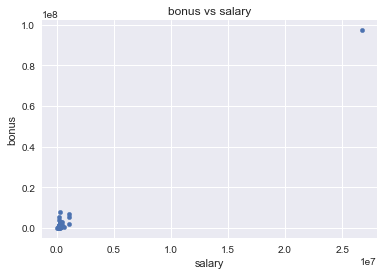

In [21]:
### look at salary and bonus, plotted
df.plot.scatter(x = 'salary', y = 'bonus', title = 'bonus vs salary')

We see there is a plotted point with over \$8,000,000 of bonuses and \$1,000,000 of salary.  
This outlier is so far away from the majaority of the points.  We will need to investigate this more.

#### Outlier investigation

In [22]:
### There is a huge outlier, further investigate who it belongs to
print "The ID with the higest salary and bonus are:\n"
print(df['salary'].idxmax())
print(df['bonus'].idxmax())


The ID with the higest salary and bonus are:

TOTAL
TOTAL


A total row is in the dataset.  This will be removed so we know we're working with a dataset of real people.

#### Remove Outlier

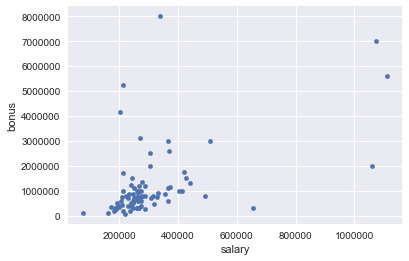

In [23]:
### Remove outliers
df.drop('TOTAL', inplace = True)

### repeat the plot
df.plot.scatter(x = 'salary', y = 'bonus')

#### Check to see if there are other entries that are obviously not a person

In [24]:
### Most names appear to follow this format:
### last name, first name, middle intitial
### because we found a name of "TOTAL",
### let's see if there is anything else to remove.      
pprint.pprint(df.index[df.index.str.split().str.len() > 3])


Index([u'BLAKE JR. NORMAN P', u'BOWEN JR RAYMOND M', u'DERRICK JR. JAMES V',
       u'DONAHUE JR JEFFREY M', u'GLISAN JR BEN F', u'OVERDYKE JR JERE C',
       u'PEREIRA PAULO V. FERRAZ', u'THE TRAVEL AGENCY IN THE PARK',
       u'WALLS JR ROBERT H', u'WHITE JR THOMAS E', u'WINOKUR JR. HERBERT S'],
      dtype='object')


In [25]:
### Most names appear to follow this format:
### last name, first name, middle intitial
### because we found a name of "TOTAL",
### let's see if there is anything else to remove.      
pprint.pprint(df.index[df.index.str.split().str.len() <= 1])


Index([], dtype='object')


The Travel Agency In The Park seems wrong.  Examine it.

#### Look at the Travel Agency Row

In [26]:
df.ix['THE TRAVEL AGENCY IN THE PARK']

salary                        NaN
to_messages                   NaN
total_payments             362096
exercised_stock_options       NaN
bonus                         NaN
restricted_stock              NaN
shared_receipt_with_poi       NaN
total_stock_value             NaN
expenses                      NaN
from_messages                 NaN
other                      362096
from_this_person_to_poi       NaN
poi                         False
email_address                 NaN
from_poi_to_this_person       NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

Because this is not a person of interest and most columns are null, we will remove this row as part of the data cleansing.

#### Remove The Travel Agency in the Park

In [27]:
### Remove outliers
df.drop('THE TRAVEL AGENCY IN THE PARK', inplace = True)

#### How many people are in the dataset now?

In [28]:
### How many people are in the dataset
print "There are", len(df.index), \
    "executives within the Enron corpus.  There used to be 146."

There are 141 executives within the Enron corpus.  There used to be 146.


In [29]:
list(df)

['salary',
 'to_messages',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_stock_value',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'email_address',
 'from_poi_to_this_person']

#### Check outliers in other features to see if there are other "people" to delete

In [30]:
### http://www.mathwords.com/o/outlier.htm
### https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.quantile.html
outliers = 1.5 * (df.quantile(.75)-df.quantile(.25))

In [31]:
### print the outlier values
outliers

salary                      145206.750
to_messages                   3121.500
total_payments             2523604.500
exercised_stock_options    2801933.250
bonus                      1162500.000
restricted_stock           1099300.875
shared_receipt_with_poi       2503.500
total_stock_value          3338798.250
expenses                     83894.250
from_messages                  186.000
other                       514245.000
from_this_person_to_poi         36.000
poi                              0.000
from_poi_to_this_person         96.000
dtype: float64

In [32]:
### show the number of times a person had an outlier value
### make sure they are real people.
(df > outliers).sum(axis=1).sort_values(ascending = False).head(25)

FREVERT MARK A         12
LAY KENNETH L          12
WHALLEY LAWRENCE G     11
LAVORATO JOHN J        11
DELAINEY DAVID W       10
BELDEN TIMOTHY N       10
SKILLING JEFFREY K      9
KITCHEN LOUISE          9
KEAN STEVEN J           9
SHANKMAN JEFFREY A      8
FALLON JAMES B          7
SHAPIRO RICHARD S       7
PAI LOU L               7
HAEDICKE MARK E         7
SHERRIFF JOHN R         7
RICE KENNETH D          7
BUY RICHARD B           7
BECK SALLY W            7
BAXTER JOHN C           7
KOPPER MICHAEL J        6
REDMOND BRIAN L         6
MCCONNELL MICHAEL S     6
ALLEN PHILLIP K         6
HANNON KEVIN P          6
YEAGER F SCOTT          6
dtype: int64

These all are real people and can remain in the dataset.

#### Add another feature

In [33]:
### createa a few ratios of emails compared to those from/to poi
df['ratio_of_to_messages_poi'] = \
    df['from_poi_to_this_person']/df['to_messages']
    
df['ratio_of_from_messages_poi'] = \
    df['from_this_person_to_poi']/df['from_messages']

In [34]:
### see a few of the rows
df[['ratio_of_to_messages_poi', 'ratio_of_from_messages_poi']].head()

,ratio_of_to_messages_poi,ratio_of_from_messages_poi
ALLEN PHILLIP K,0.016196,0.029613
BADUM JAMES P,NaN,NaN
BANNANTINE JAMES M,0.068905,0.000000
BAXTER JOHN C,NaN,NaN
BAY FRANKLIN R,NaN,NaN


In [35]:
### replace the NaNs with 0s.
### we are ready to put this back in a dictionary for ML
df.replace(to_replace = 'NaN', value = 0, inplace=True)

### change the pandas dataframe to a dictionary
### https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_dict.html
my_dict = df.to_dict('index')

In [36]:
### print one  out to make sure it looks right
iterator = 0

for key in my_dict:
    if iterator < 1:
        print key
        pprint.pprint(my_dict[key])
        iterator += 1

METTS MARK
{'bonus': 600000.0,
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 0.0,
 'expenses': 94299.0,
 'from_messages': 29.0,
 'from_poi_to_this_person': 38.0,
 'from_this_person_to_poi': 1.0,
 'other': 1740.0,
 'poi': False,
 'ratio_of_from_messages_poi': 0.034482758620689655,
 'ratio_of_to_messages_poi': 0.04708798017348203,
 'restricted_stock': 585062.0,
 'salary': 365788.0,
 'shared_receipt_with_poi': 702.0,
 'to_messages': 807.0,
 'total_payments': 1061827.0,
 'total_stock_value': 585062.0}


In [44]:
features_list = [
                 'poi'
                ,'bonus'
                ,'exercised_stock_options'
                ,'expenses'
                ,'from_messages'
                ,'from_poi_to_this_person'
                ,'from_this_person_to_poi'
                ,'other'
                ,'ratio_of_to_messages_poi'
                ,'restricted_stock'
                ,'salary'
                ,'shared_receipt_with_poi'
                ,'to_messages'
                ,'total_payments'
                ,'total_stock_value'
                 ]

In [45]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [55]:
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

clf.fit(features_train, labels_train)
accuracy = clf.score(features_test,labels_test)
print("\n Accuracy of Model: %0.3F %%" % (accuracy*100))

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### tht the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dict, features_list)
test_classifier(clf, my_dict, features_list)


 Accuracy of Model: 86.047 %
GaussianNB(priors=None)
	Accuracy: 0.83933	Precision: 0.33086	Recall: 0.20050	F1: 0.24969	F2: 0.21765
	Total predictions: 15000	True positives:  401	False positives:  811	False negatives: 1599	True negatives: 12189



### Conclusions

### Assumptions

##### Sources, Credits, Footnote

##### Version History
1.0, 06/30/2017, Created